# Membuat model R-CNN dari dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2
import os

import tensorflow as tf
import tensorflow_hub

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

In [2]:
train_dir = '../../data/training_images_labeled-3/for_rcnn/'

batch_size = 32
target_size = (224, 224)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=0.2,
                                                                brightness_range=[0.9,1.5],
                                                                horizontal_flip=True,
                                                                validation_split=0.2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        train_dir,
        class_mode='categorical',
        color_mode='rgb',
        target_size=target_size,
        batch_size=batch_size,
        subset='training')

val_generator = train_datagen.flow_from_directory(
        train_dir,
        class_mode='categorical',
        color_mode='rgb',
        target_size=target_size,
        batch_size=batch_size,
        subset='validation',
        shuffle=False)

Found 319 images belonging to 2 classes.
Found 78 images belonging to 2 classes.


In [3]:
base_model = tf.keras.applications.MobileNetV3Small(include_top=False,input_shape=(target_size[0], target_size[0], 3))
base_model.trainable = False

In [4]:
i = tf.keras.layers.Input([target_size[0], target_size[0], 3])
x = tf.cast(i, tf.float32)
x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(8, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=i,outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 16)                451600    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                             

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
# precision = tf.keras.metrics.Precision()
# recall = tf.keras.metrics.Recall()
# AUC = tf.keras.metrics.AUC()
model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, restore_best_weights=True, verbose=0)
# reduceLRonplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=0)
checkpoint = tf.keras.callbacks.ModelCheckpoint('../../models/Esha_R_CNN_3.h5',save_format='h5', monitor='val_accuracy', save_best_only=True,verbose=0)

tf.keras.backend.clear_session()

history = model.fit(train_generator,validation_data = val_generator,epochs=200, callbacks=[early_stopping,checkpoint],verbose=1)

Epoch 1/200
10/10 [==============================] - 20s 1s/step - loss: 0.8384 - accuracy: 0.6082 - val_loss: 0.5835 - val_accuracy: 0.7821
Epoch 2/200
10/10 [==============================] - 11s 1s/step - loss: 0.5443 - accuracy: 0.7116 - val_loss: 0.4032 - val_accuracy: 0.8846
Epoch 3/200
10/10 [==============================] - 12s 1s/step - loss: 0.3644 - accuracy: 0.8464 - val_loss: 0.3696 - val_accuracy: 0.8846
Epoch 4/200
10/10 [==============================] - 12s 1s/step - loss: 0.3511 - accuracy: 0.8401 - val_loss: 0.2840 - val_accuracy: 0.9103
Epoch 5/200
10/10 [==============================] - 15s 2s/step - loss: 0.2749 - accuracy: 0.8871 - val_loss: 0.2118 - val_accuracy: 0.9231
Epoch 6/200
10/10 [==============================] - 12s 1s/step - loss: 0.2907 - accuracy: 0.8652 - val_loss: 0.2229 - val_accuracy: 0.9231
Epoch 7/200
10/10 [==============================] - 11s 1s/step - loss: 0.2195 - accuracy: 0.9279 - val_loss: 0.2433 - val_accuracy: 0.9103


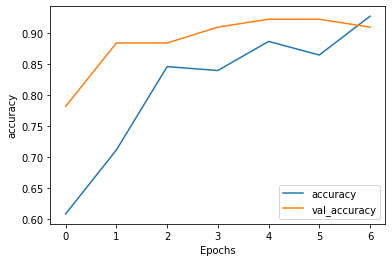

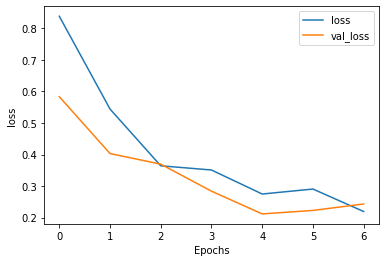

In [6]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [7]:
base_model.trainable = True
model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),metrics=['accuracy'])
model.fit(train_generator,validation_data = val_generator,epochs=100, callbacks=[early_stopping,checkpoint],verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 16)                451600    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                             

In [8]:
model_best = tf.keras.models.load_model('../../models/Esha_R_CNN_3.h5')

vid_5_26720.jpg


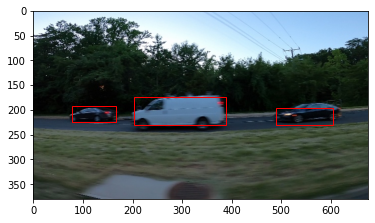

In [10]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
max_proposed_boxes = 300

i = '../../data/testing_images/vid_5_26720.jpg'
filename = i.split('/')[-1]
print(filename)

counter = 0
    
img = load_img(i)
normalized_img_array = img_to_array(img)

ss.setBaseImage(img_to_array(img))
ss.switchToSelectiveSearchFast()
rects = ss.process()

car_boxes = []
probas = []

for (x, y, w, h) in rects:

    if counter <= max_proposed_boxes:
        counter += 1
        filename_box = filename
        proposed_box = [x, y, x + w, y + h]

        image_array = normalized_img_array[proposed_box[1]:proposed_box[3],proposed_box[0]:proposed_box[2]]
        image_array = cv2.resize(image_array,target_size)

        predicted = model_best.predict(image_array.reshape(1,target_size[0],target_size[0],3), verbose=0)

        if np.argmax(predicted) == 1 and predicted[0][1] >= 0.5:
            car_boxes.append([y, x, y + h, x + w])
            probas.append(predicted[0][1])

img_w, img_h = 676, 380

im = Image.open(i)
fig, ax = plt.subplots()
ax.imshow(im)

try:
    selected_indices = tf.image.non_max_suppression(car_boxes, probas, 100, iou_threshold=0.0)
    selected_boxes = tf.gather(car_boxes, selected_indices)
    for i in selected_boxes:
        ymin, xmin, ymax, xmax = i[0], i[1], i[2], i[3]
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
except:
    pass
plt.show()